# Illustrate the Embedding Layer and GloVe on Trip Advisor Review Dataset

In [1]:
import pandas as pd
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('max_colwidth', 100)
import gensim
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
from keras.utils import to_categorical


In [2]:
 # Note you should have 4.1.2
print("gensim version is",gensim.__version__ )
if gensim.__version__ != '4.1.2':
    print ("Note you need to update gensim using pip install -U gensum")

gensim version is 4.2.0
Note you need to update gensim using pip install -U gensum


# 1. Some constants 

In [3]:
max_review_length = 300 # no of words per review.  reviews will be  truncated or padded to be of this length.
max_words = 10000        # this is the size of the index (i.e. most common top words that will be used as features)                       # note code assumes there are enough words in reviews.
embedding_dim = 100    # size of embedding.

traning_samples= 10000
validation_samples = 6000

# 2. Reading in the data

In [4]:
import os
data_dir = "./data"
tripadvisor_df = pd.read_csv(os.path.join( data_dir, 'tripadvisor_hotel_reviews.csv.zip'))
print(" tripadvisor_df shape: ", tripadvisor_df.shape)
tripadvisor_df.head()

               

 tripadvisor_df shape:  (20491, 2)


,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


# 3.Data Analysis and Visualisation

Text(0.5, 1.0, ' Class Distribution Tripadvisor Hotel Reviews  ')

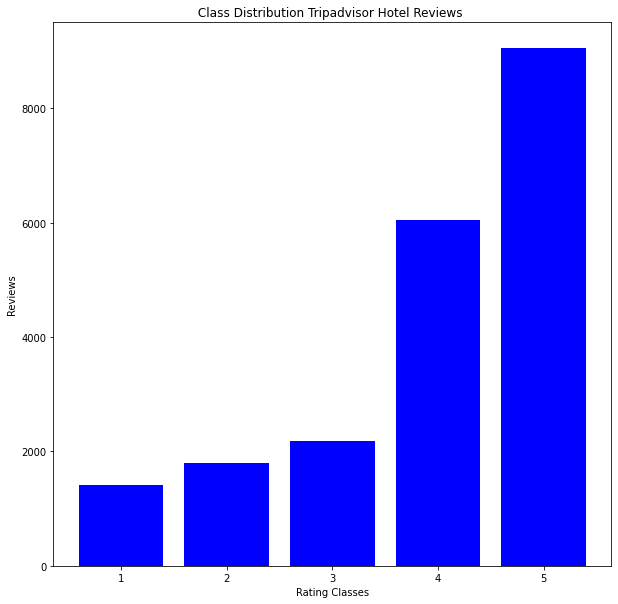

In [5]:
rating_counts = tripadvisor_df['Rating'].value_counts()

plt.figure(figsize=(10,10))

plt.bar( rating_counts.index , rating_counts.values , color="blue")
              
plt.xlabel("Rating Classes")
plt.ylabel("Reviews")
plt.title(" Class Distribution Tripadvisor Hotel Reviews  ")


In [6]:
texts = tripadvisor_df['Review'].values
print(texts[10])

poor value stayed monaco seattle july, nice hotel priced 100- 150 night not, hotel takes beating quotient, experience simply average, nothing exceptional paying 300+ n't ca n't terribly disappointed, wife stayed nicest suites 200/night felt like overpaying, best advice shop, quality-wise league average marriott nice best western,  


In [7]:
# Encode target variable Rating, into a one hot vector.

encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }
labels = ['1', '2', '3', '4', '5']

ratings = tripadvisor_df['Rating'].copy()
ratings.replace(encoding, inplace=True)
ratings = to_categorical(ratings,5)

In [8]:
# use the tokenizers to code the reviews

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print(f' Found {len(word_index)} unique tokens')

sequences = tokenizer.texts_to_sequences(texts)

print("Line 1 :", texts[1])
print("\nCoded :  " , sequences[2])


 Found 52211 unique tokens
Line 1 : ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, 5 day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty did not reply solution, send email trip guest survey did not follow email mail, guess tell concerned guest.the staff ranged indifferent not helpful, asked desk good breakfast spots neighborhood hood told no hotels, gee best breakfast spots seattle 1/2 block away convenient hotel does not know exist, arrived lat

In [9]:
max_length = max([len(x) for x in sequences])
vocab_size = len(tokenizer.word_index)+1 #add 1 to account for unknown word
print("Vocabulary size: {}".format(vocab_size))
print("Max length of sentence: {}".format(max_length))

Vocabulary size: 52212
Max length of sentence: 1894


In [10]:
# Create fixed size sequences
import numpy as np

data = pad_sequences(sequences , maxlen = max_length)

ratings = np.asarray(ratings)
print( 'Shape of data = ' , data.shape)
print( 'Shape of Lables = ' ,  ratings.shape)


Shape of data =  (20491, 1894)
Shape of Lables =  (20491, 5)


We can see that most ratings are 5-star ratings and the least are 1-star ratings. Thus we must take care to train our model on enough 1-star ratings. Thus while training the data, we must stratify our dataset our data. This will ensure that the distribution of all the classes is even between the train, validation, and test set. This will help prevent unknown classes from appearing in the validation or test set.

In [11]:
from sklearn.model_selection import train_test_split
 
x_train, x_val, y_train, y_val = train_test_split(data, ratings, test_size= 0.1, shuffle=True , random_state=42 , stratify = ratings )
print( "x_train size = " , str( len(x_train)))
print("x_val size = " , str(len( x_val)))
print("y_train size = " , str(len( y_train )))
print( "y_val size = " , str(len( y_val )))

x_train size =  18441
x_val size =  2050
y_train size =  18441
y_val size =  2050


# 4. Use GloVe embeddings

In [12]:
glove_dir = './glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir , 'glove.6B.100d.txt') , encoding= 'utf-8')
for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:] , dtype = 'float32')
        embeddings_index[word] = coefs
f.close()

print('no of words in glove embeddings = ' , len(embeddings_index))


no of words in glove embeddings =  400000


In [13]:
#look for word embeddings, limiting the vector to 100

embeddings_matrix = np.zeros((max_words , embedding_dim))

for word,i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

# print some entities

for word, i in word_index.items():
    if i > 10 : break
    print(f'{i}:{word} \t--> {embeddings_matrix[i , 0:6]}')

1:hotel 	--> [ 0.43044001 -0.71715999  0.13989     0.59311002 -0.16727     0.56128001]
2:room 	--> [-0.024843    0.47766     0.32437    -0.054239   -0.47622001  1.10430002]
3:not 	--> [-0.19103999  0.17601     0.36919999 -0.50322998 -0.47560999  0.15798   ]
4:great 	--> [-0.013786    0.38216001  0.53236002  0.15261    -0.29694    -0.20558   ]
5:n't 	--> [ 0.15730999  0.3953      0.63586003 -1.09749997 -0.95767999 -0.013841  ]
6:good 	--> [-0.030769    0.11993     0.53908998 -0.43696001 -0.73936999 -0.15345   ]
7:staff 	--> [-0.61250001 -0.29506999 -0.28917    -0.36431    -0.39695001  0.097624  ]
8:stay 	--> [-0.41615999 -0.26538     0.21720999 -0.26014999 -0.18043999  0.38745001]
9:did 	--> [ 0.30449    -0.19628     0.20225    -0.61686999 -0.68484002 -0.11887   ]
10:just 	--> [ 0.075026    0.39324999  0.90314001 -0.30451    -0.32767999  0.59630001]


In [14]:
max_review_length = 300 # no of words per review.  reviews will be  truncated or padded to be of this length.
max_words = 10000        # this is the size of the index (i.e. most common top words that will be used as features)                       # note code assumes there are enough words in reviews.
embedding_dim = 100    # size of embedding.


traning_samples= 10000
validation_samples = 6000


# Vocabulary size: 52212
# Max length of sentence: 300

# 5. Define a Network

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten , Dense

network_g = Sequential()
network_g.add(Embedding(max_words , embedding_dim , input_length =  max_length, weights=[embeddings_matrix] , trainable = False))
network_g.add(Flatten())
network_g.add(Dense(32 , activation = 'relu'))
network_g.add(Dense(5 , activation = 'softmax'))
network_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1894, 100)         1000000   
                                                                 
 flatten (Flatten)           (None, 189400)            0         
                                                                 
 dense (Dense)               (None, 32)                6060832   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 7,060,997
Trainable params: 6,060,997
Non-trainable params: 1,000,000
_________________________________________________________________


In [23]:
network_g.compile(optimizer= 'rmsprop' , loss= 'binary_crossentropy' , metrics= ['acc'])
hist_g = network_g.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Train on 18441 samples, validate on 2050 samples
Epoch 1/20
18441/18441 [==============================] - 35s 2ms/step - loss: 0.3990 - acc: 0.8206 - val_loss: 0.3740 - val_acc: 0.8263
Epoch 2/20
18441/18441 [==============================] - 34s 2ms/step - loss: 0.3227 - acc: 0.8480 - val_loss: 0.3705 - val_acc: 0.8258
Epoch 3/20
18441/18441 [==============================] - 36s 2ms/step - loss: 0.2658 - acc: 0.8792 - val_loss: 0.4194 - val_acc: 0.8115
Epoch 4/20
18441/18441 [==============================] - 35s 2ms/step - loss: 0.2139 - acc: 0.9070 - val_loss: 0.4846 - val_acc: 0.7898
Epoch 5/20
18441/18441 [==============================] - 34s 2ms/step - loss: 0.1674 - acc: 0.9317 - val_loss: 0.5292 - val_acc: 0.8000
Epoch 6/20
18441/18441 [==============================] - 35s 2ms/step - loss: 0.1267 - acc: 0.9514 - val_loss: 0.5775 - val_acc: 0.8039
Epoch 7/20
18441/18441 [==============================] - 37s 2ms/step - loss: 0.0938 - acc: 0.9648 - val_loss: 0.6502 - val_acc:

In [24]:
network_g.save('models/network_g')

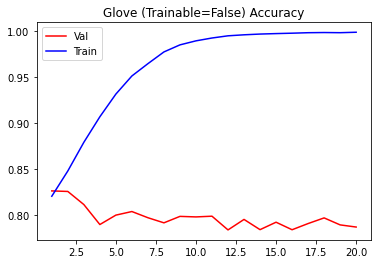

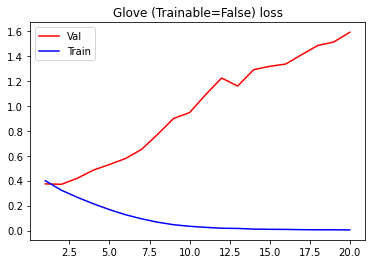

In [25]:
import matplotlib.pyplot as plt


acc_g = hist_g.history['acc']
val_acc_g= hist_g.history['val_acc']

# acc = hist['acc']
# val_acc= hist.history['val_acc']

epochs = range(1,len(acc_g)+1)

plt.plot(epochs , val_acc_g ,'r' ,label= 'Val')
# plt.plot(epochs , val_acc, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainable=False) Accuracy")
plt.plot(epochs , acc_g ,'b' ,label= 'Train')
# plt.plot(epochs , acc, 'b', label= 'Without Glove')

plt.legend()
plt.show()



loss_g = hist_g.history['loss']
val_loss_g= hist_g.history['val_loss']

# loss = hist['loss']
# val_loss= hist.history['val_loss']

epochs = range(1,len(loss_g)+1)

plt.plot(epochs , val_loss_g ,'r' ,label= 'Val')
# plt.plot(epochs , val_loss, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainable=False) loss")
plt.plot(epochs , loss_g ,'b' ,label= 'Train')
# plt.plot(epochs , loss, 'b', label= 'Without Glove')

plt.legend()
plt.show()


# 6. Define LSTM Network using GloVe  

In [16]:

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

network_g_lstm = Sequential()
network_g_lstm.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False))
network_g_lstm.add(Bidirectional(LSTM(64)))
network_g_lstm.add(Dropout(0.5))
network_g_lstm.add(Dense(128, activation='relu'))
network_g_lstm.add(Dropout(0.5))
network_g_lstm.add(Dense(64, activation='relu'))
network_g_lstm.add(Dropout(0.5))
network_g_lstm.add(Dense(5 , activation = 'softmax'))
network_g_lstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1894, 100)         1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                      

In [17]:
network_g_lstm.compile(optimizer= 'Adam' , loss= 'mse' , metrics= ['acc'])
hist_g_lstm = network_g_lstm.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Epoch 1/20
577/577 [==============================] - 1073s 2s/step - loss: 0.1332 - acc: 0.4498 - val_loss: 0.1298 - val_acc: 0.4756
Epoch 2/20
577/577 [==============================] - 939s 2s/step - loss: 0.1196 - acc: 0.5069 - val_loss: 0.1089 - val_acc: 0.5561
Epoch 3/20
577/577 [==============================] - 868s 2s/step - loss: 0.1104 - acc: 0.5590 - val_loss: 0.1051 - val_acc: 0.5795
Epoch 4/20
577/577 [==============================] - 810s 1s/step - loss: 0.1071 - acc: 0.5819 - val_loss: 0.1014 - val_acc: 0.5917
Epoch 5/20
577/577 [==============================] - 766s 1s/step - loss: 0.1025 - acc: 0.6018 - val_loss: 0.1007 - val_acc: 0.6049
Epoch 6/20
577/577 [==============================] - 849s 1s/step - loss: 0.1005 - acc: 0.6152 - val_loss: 0.1007 - val_acc: 0.5961
Epoch 7/20
577/577 [==============================] - 768s 1s/step - loss: 0.0975 - acc: 0.6286 - val_loss: 0.1026 - val_acc: 0.5932
Epoch 8/20
577/577 [==============================] - 739s 1s/step -

In [19]:
network_g_lstm.save('models/network_g_lstm')

INFO:tensorflow:Assets written to: models/network_g_lstm\assets


INFO:tensorflow:Assets written to: models/network_g_lstm\assets


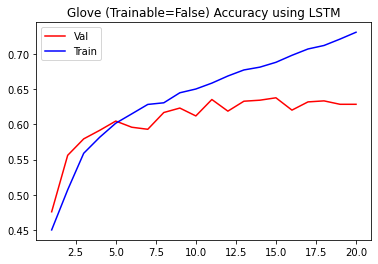

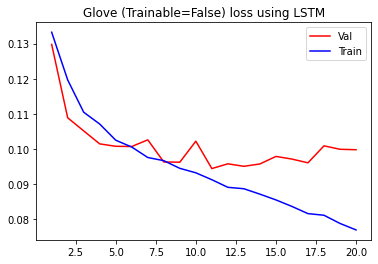

In [20]:
import matplotlib.pyplot as plt


acc_g_lstm = hist_g_lstm.history['acc']
val_acc_g_lstm= hist_g_lstm.history['val_acc']

# acc = hist['acc']
# val_acc= hist.history['val_acc']

epochs = range(1,len(acc_g_lstm)+1)

plt.plot(epochs , val_acc_g_lstm ,'r' ,label= 'Val')
# plt.plot(epochs , val_acc, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainable=False) Accuracy using LSTM")
plt.plot(epochs , acc_g_lstm ,'b' ,label= 'Train')
# plt.plot(epochs , acc, 'b', label= 'Without Glove')

plt.legend()
plt.show()


loss_g_lstm = hist_g_lstm.history['loss']
val_loss_g_lstm= hist_g_lstm.history['val_loss']

# loss = hist['loss']
# val_loss= hist.history['val_loss']

epochs = range(1,len(loss_g_lstm)+1)

plt.plot(epochs , val_loss_g_lstm ,'r' ,label= 'Val')
# plt.plot(epochs , val_loss, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainable=False) loss using LSTM")
plt.plot(epochs , loss_g_lstm ,'b' ,label= 'Train')
# plt.plot(epochs , loss, 'b', label= 'Without Glove')

plt.legend()
plt.show()

# 7. Define LSTM using Glove (trainable=True) 

In [ ]:
network_g_lstm_trainable = Sequential()
network_g_lstm_trainable.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=True))
network_g_lstm_trainable.add(Bidirectional(LSTM(64)))
network_g_lstm_trainable.add(Dropout(0.5))
network_g_lstm_trainable.add(Dense(128, activation='relu'))
network_g_lstm_trainable.add(Dropout(0.5))
network_g_lstm_trainable.add(Dense(64, activation='relu'))
network_g_lstm_trainable.add(Dropout(0.5))
network_g_lstm_trainable.add(Dense(5 , activation = 'softmax'))
network_g_lstm_trainable.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1894, 100)         1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
network_g_lstm_trainable.compile(optimizer= 'Adam' , loss= 'mse' , metrics= ['acc'])
hist_g_lstm_trainable = network_g_lstm_trainable.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Epoch 1/20
577/577 [==============================] - 1562s 3s/step - loss: 0.1317 - acc: 0.4562 - val_loss: 0.1199 - val_acc: 0.5063
Epoch 2/20
577/577 [==============================] - 1371s 2s/step - loss: 0.1223 - acc: 0.4896 - val_loss: 0.1097 - val_acc: 0.5429
Epoch 3/20
577/577 [==============================] - 1387s 2s/step - loss: 0.1148 - acc: 0.5388 - val_loss: 0.1063 - val_acc: 0.5790
Epoch 4/20
577/577 [==============================] - 1488s 3s/step - loss: 0.1017 - acc: 0.6067 - val_loss: 0.0987 - val_acc: 0.6220
Epoch 5/20
577/577 [==============================] - 1412s 2s/step - loss: 0.0924 - acc: 0.6547 - val_loss: 0.0953 - val_acc: 0.6351
Epoch 6/20
577/577 [==============================] - 1472s 3s/step - loss: 0.0844 - acc: 0.6951 - val_loss: 0.1000 - val_acc: 0.6327
Epoch 7/20
577/577 [==============================] - 1384s 2s/step - loss: 0.0762 - acc: 0.7354 - val_loss: 0.0993 - val_acc: 0.6278
Epoch 8/20
577/577 [==============================] - 1426s 2s

In [ ]:
network_g_lstm.save('models/network_g_lstm_trainable')

INFO:tensorflow:Assets written to: models/network_g_lstm_trainable\assets


INFO:tensorflow:Assets written to: models/network_g_lstm_trainable\assets


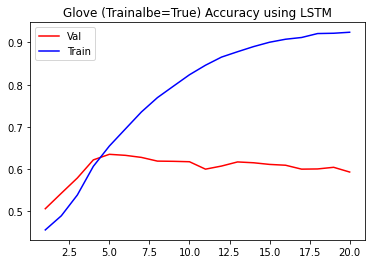

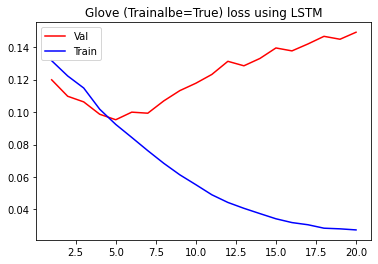

In [ ]:
acc_g_lstm_trainable = hist_g_lstm_trainable.history['acc']
val_acc_g_lstm_trainable = hist_g_lstm_trainable.history['val_acc']

# acc = hist['acc']
# val_acc= hist.history['val_acc']

epochs = range(1,len(acc_g_lstm_trainable)+1)

plt.plot(epochs , val_acc_g_lstm_trainable ,'r' ,label= 'Val')
# plt.plot(epochs , val_acc, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainalbe=True) Accuracy using LSTM")
plt.plot(epochs , acc_g_lstm_trainable ,'b' ,label= 'Train')
# plt.plot(epochs , acc, 'b', label= 'Without Glove')

plt.legend()
plt.show()

loss_g_lstm_trainable = hist_g_lstm_trainable.history['loss']
val_loss_g_lstm_trainable= hist_g_lstm_trainable.history['val_loss']

# loss = hist['loss']
# val_loss= hist.history['val_loss']

epochs = range(1,len(loss_g_lstm_trainable)+1)

plt.plot(epochs , val_loss_g_lstm_trainable ,'r' ,label= 'Val')
# plt.plot(epochs , val_loss, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove (Trainalbe=True) loss using LSTM")
plt.plot(epochs , loss_g_lstm_trainable ,'b' ,label= 'Train')
# plt.plot(epochs , loss, 'b', label= 'Without Glove')

plt.legend()
plt.show()

# 8. Define RNN Network using GloVe

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense

network_g_rnn = Sequential()
network_g_rnn.add(Embedding(max_words, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False))
network_g_rnn.add(SimpleRNN(64))
network_g_rnn.add(Dropout(0.5))
network_g_rnn.add(Dense(128, activation='relu'))
network_g_rnn.add(Dropout(0.5))
network_g_rnn.add(Dense(64, activation='relu'))
network_g_rnn.add(Dropout(0.5))
network_g_rnn.add(Dense(5 , activation = 'softmax'))
network_g_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1894, 100)         1000000   
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [ ]:
network_g_rnn.compile(optimizer= 'Adam' , loss= 'mse' , metrics= ['acc'])
hist_g_rnn = network_g_rnn.fit( x_train , y_train , epochs= 20 , batch_size= 32 , validation_data= (x_val,y_val))

Epoch 1/20
577/577 [==============================] - 127s 219ms/step - loss: 0.1452 - acc: 0.4083 - val_loss: 0.1423 - val_acc: 0.4371
Epoch 2/20
577/577 [==============================] - 128s 222ms/step - loss: 0.1384 - acc: 0.4341 - val_loss: 0.1389 - val_acc: 0.4424
Epoch 3/20
577/577 [==============================] - 134s 231ms/step - loss: 0.1384 - acc: 0.4405 - val_loss: 0.1388 - val_acc: 0.4420
Epoch 4/20
577/577 [==============================] - 133s 230ms/step - loss: 0.1392 - acc: 0.4410 - val_loss: 0.1393 - val_acc: 0.4420
Epoch 5/20
577/577 [==============================] - 124s 216ms/step - loss: 0.1379 - acc: 0.4412 - val_loss: 0.1361 - val_acc: 0.4420
Epoch 6/20
577/577 [==============================] - 105s 183ms/step - loss: 0.1375 - acc: 0.4402 - val_loss: 0.1383 - val_acc: 0.4415
Epoch 7/20
577/577 [==============================] - 106s 183ms/step - loss: 0.1366 - acc: 0.4430 - val_loss: 0.1363 - val_acc: 0.4424
Epoch 8/20
577/577 [============================

In [ ]:
network_g_rnn.save('models/network_g_rnn')

INFO:tensorflow:Assets written to: models/network_g_rnn\assets


INFO:tensorflow:Assets written to: models/network_g_rnn\assets


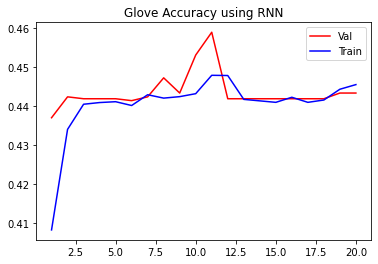

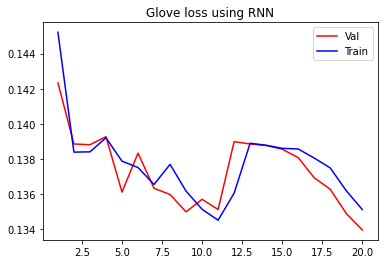

In [ ]:
acc_g_rnn = hist_g_rnn.history['acc']
val_acc_g_rnn= hist_g_rnn.history['val_acc']

# acc = hist['acc']
# val_acc= hist.history['val_acc']

epochs = range(1,len(acc_g_rnn)+1)

plt.plot(epochs , val_acc_g_rnn ,'r' ,label= 'Val')
# plt.plot(epochs , val_acc, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove Accuracy using RNN")
plt.plot(epochs , acc_g_rnn ,'b' ,label= 'Train')
# plt.plot(epochs , acc, 'b', label= 'Without Glove')

plt.legend()
plt.show()

loss_g_rnn = hist_g_rnn.history['loss']
val_loss_g_rnn= hist_g_rnn.history['val_loss']

# loss = hist['loss']
# val_loss= hist.history['val_loss']

epochs = range(1,len(loss_g_rnn)+1)

plt.plot(epochs , val_loss_g_rnn ,'r' ,label= 'Val')
# plt.plot(epochs , val_loss, 'b', label= 'Without Glove')

# plt.legend()
# plt.show()

plt.title("Glove loss using RNN")
plt.plot(epochs , loss_g_rnn ,'b' ,label= 'Train')
# plt.plot(epochs , loss, 'b', label= 'Without Glove')

plt.legend()
plt.show()